In [27]:
# import whisper
import pyaudio
import numpy as np
import wave
import os
import noisereduce as nr
import matplotlib.pyplot as plt
import keyboard
from IPython.display import Audio, display

In [28]:
# List available input audio devices and their names
p = pyaudio.PyAudio()
print("Available input devices:")
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    print(f"{i}: {device_info['name']}")

Available input devices:
0: Microsoft Sound Mapper - Input
1: Mic in at front panel (black) (
2: Stereo Mix (Realtek High Defini
3: Microphone (Realtek High Defini
4: Microsoft Sound Mapper - Output
5: Speaker/Headphone (Realtek High
6: Microphone (Realtek HD Audio Mic input)
7: Speakers (Realtek HD Audio output)
8: Mic in at front panel (black) (Mic in at front panel (black))
9: Stereo Mix (Realtek HD Audio Stereo input)


In [29]:
# Select the desired input device by its ID (replace with the appropriate ID)
selected_device_id = 1  # Change this to the ID of your desired input device

# Record audio from the selected input device
print(f"Recording audio will use device: '{p.get_device_info_by_index(selected_device_id)['name']}'")

Recording audio will use device: 'Mic in at front panel (black) ('


In [56]:
# Function to start recording
def start_recording():
    global recording
    recording = True
    print("Recording audio. Press the space key to stop...")

# Function to stop recording
def stop_recording():
    global recording
    recording = False
    print("Recording stopped.")

# Function to reduce noise from audio
def reduce_noise(audio_data, sample_rate):
    # Apply noise reduction using the noisereduce library
    reduced_audio = nr.reduce_noise(y=audio_data, sr=sample_rate)
    return reduced_audio

# Set the parameters for audio recording
sample_rate = 16000  # You can adjust this based on your needs
duration = 10  # Maximum recording duration in seconds

# Initialize recording status
recording = False
audio = []

# Create a directory for recordings
output_dir = "recordings"
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
output_file = os.path.join(output_dir, "recorded_audio.wav")

# Callback function for audio recording
def audio_callback(in_data, frame_count, time_info, status):
    if recording:
        audio.append(in_data)
    return (in_data, pyaudio.paContinue)

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open an audio stream for recording
stream = p.open(format=pyaudio.paInt16,
                channels=1,
                rate=sample_rate,
                input=True,
                input_device_index=selected_device_id,
                frames_per_buffer=1024,
                stream_callback=audio_callback)

# Wait for the space key to start recording
print("Press the space key to start recording...")
keyboard.wait("space")
start_recording()

# Wait for the space key to stop recording
print("Recording audio. Press the space key to stop...")
keyboard.wait("space")
stop_recording()

# Close the audio stream
stream.stop_stream()
stream.close()
p.terminate()

Press the space key to start recording...
Recording audio. Press the space key to stop...
Recording audio. Press the space key to stop...
Recording stopped.


In [57]:
# Save the recorded audio as a WAV file
if audio:
    audio_data = b''.join(audio)
    with wave.open(output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(audio_data)

    print(f"Audio saved as {output_file}")
else:
    print("No audio recorded.")

# Reduce noise from the recorded audio
if os.path.exists(output_file):
    with wave.open(output_file, 'rb') as wf:
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)
        sample_rate = wf.getframerate()
    
    # Reduce noise from the recorded audio
    reduced_audio = reduce_noise(audio_data, sample_rate)
    
    # Save the reduced audio
    reduced_output_file = os.path.join(output_dir, "reduced_audio.wav")
    with wave.open(reduced_output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(reduced_audio.tobytes())
    
    print(f"Noise reduced audio saved as {reduced_output_file}")

Audio saved as recordings\recorded_audio.wav
Noise reduced audio saved as recordings\reduced_audio.wav


Numerical representation of the recorded audio:
[  67   65   65 ... -105 -100 -104]


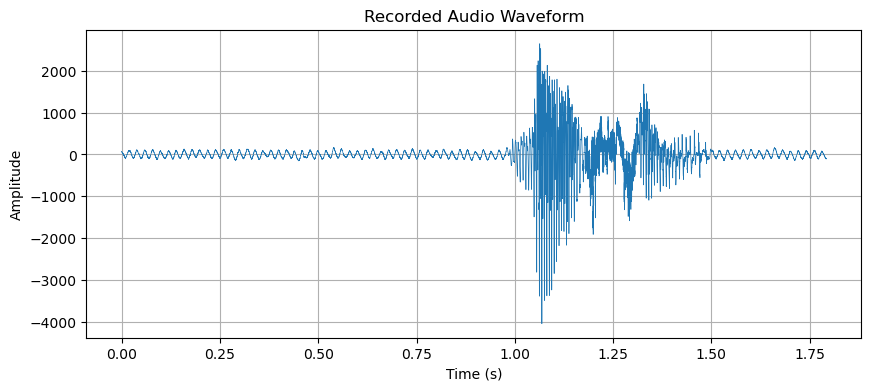

Numerical representation of the reduced audio:
[ 1  1  0 ...  0 -1 -1]


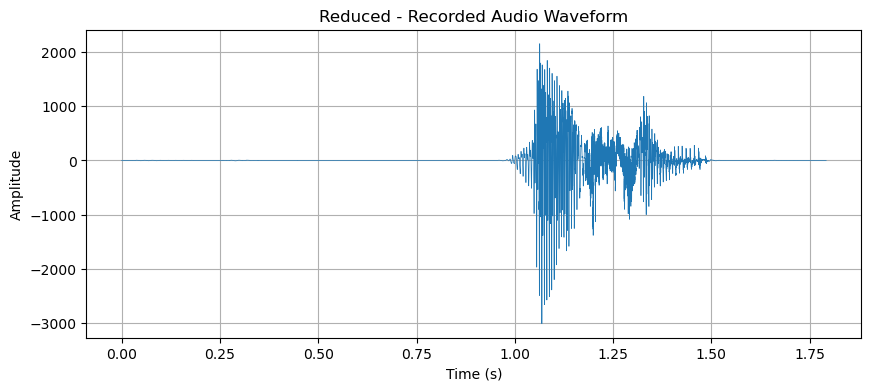

In [58]:
# # Load the recorded audio using whisper
# signal, _ = whisper.load(output_file)

# Load the recorded audio file
audio_file = "recordings/recorded_audio.wav"

# Load the reduced audio file
reduced_audio_file = "recordings/reduced_audio.wav"

# Open the audio file if exist
if os.path.exists(output_file):
    with wave.open(audio_file, 'rb') as wf:
        # Get audio data
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Get sample rate and duration
        sample_rate = wf.getframerate()
        duration = len(audio_data) / sample_rate

    # Create a time array for x-axis (in seconds)
    time = np.linspace(0, duration, len(audio_data))

    # # Adjust NumPy print options to display the full array without truncation
    # np.set_printoptions(threshold=np.inf)

    # Print the numerical representation of the audio
    print("Numerical representation of the recorded audio:")
    print(audio_data)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, lw=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Recorded Audio Waveform")
    plt.grid(True)
    plt.show()

    # Play the recorded audio in the notebook
    display(Audio(filename=output_file))

# Open the reduced audio file if exist
if os.path.exists(reduced_output_file):
    with wave.open(reduced_output_file, 'rb') as wf:
        # Get audio data
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Get sample rate and duration
        sample_rate = wf.getframerate()
        duration = len(audio_data) / sample_rate

    # Create a time array for x-axis (in seconds)
    time = np.linspace(0, duration, len(audio_data))
    
    # # Adjust NumPy print options to display the full array without truncation
    # np.set_printoptions(threshold=np.inf)

    # Print the numerical representation of the audio
    print("Numerical representation of the reduced audio:")
    print(audio_data)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, lw=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Reduced - Recorded Audio Waveform")
    plt.grid(True)
    plt.show()

    # # Plot the spectrogram of the reduced audio
    # plt.figure(figsize=(10, 6))
    # plt.specgram(reduced_audio, Fs=sample_rate, cmap="viridis")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Frequency (Hz)")
    # plt.title("Spectrogram of Noise-Reduced Audio")
    # plt.colorbar(label="Intensity (dB)")
    # plt.show()

    # Play the recorded audio in the notebook
    display(Audio(filename=reduced_output_file))

In [ ]:
# You can now perform voice recognition using the extracted features
# This may involve training a machine learning model or using a pre-trained model
# The specific recognition process will depend on your use case